In [2]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D,MaxPooling3D, TimeDistributed, Conv2D, LSTM, SimpleRNN, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

import io
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import r2_score
# from IPython.display import Image, display
# from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa

from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, LSTM
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
import tensorflow as tf


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to enco

In [3]:
def load_data():
    data = []
    path = rf"{os.getcwd()}\src\yearly_data"
    for file in os.listdir(path):
        df = pd.read_csv(f'{path}/{file}')
        df.drop(columns=[df.columns[0]], axis=1, inplace=True)
        df.fillna(0.0, inplace=True)
        data.append(df.to_numpy())
    return np.array(data)

data = load_data()


In [4]:
full_data = data
full_data.shape

(40, 277, 228)

In [5]:
data = full_data

In [6]:
data_shifted = data[2:]
data_shifted.shape

(38, 277, 228)

In [7]:
data = data[:-2]
data.shape

(38, 277, 228)

In [8]:
data.shape

(38, 277, 228)

In [9]:
data = data.reshape((38, 277, 228, 1))
# data = data.reshape((2100, 277, 228, 1))

In [10]:
data.shape

(38, 277, 228, 1)

In [142]:
data[0][0][0]

array([49.02999878])

In [11]:
train_dataset = data[:32]
train_labels = data_shifted[:32]
test_dataset = data[-6:]
test_labels = data_shifted[-6:]
# train_dataset = data[:1700]
# train_labels = data_shifted[:1700]
# test_dataset = data[-400:]
# test_labels = data_shifted[-400:]
print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

Training Dataset Shapes: (32, 277, 228, 1), (32, 277, 228)
Validation Dataset Shapes: (6, 277, 228, 1), (6, 277, 228)


In [128]:
# dataset = [data[0], data[1]]
# dataset_test = load_real_samples('F:\Jyoti Shukla -MS\karnataka dataset\paired_padded_arrays_test_total_AVHRR_data.npz')
# train_dataset, train_labels = dataset[0],dataset[1]
# test_dataset, test_labels = dataset_test[0], dataset_test[1]
# # Inspect the dataset.
# print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
# print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))

In [12]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [13]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (28, 4, 277, 228, 1), (28, 4, 277, 228, 1)
Validation Dataset Shapes: (2, 4, 277, 228, 1), (2, 4, 277, 228, 1)


In [200]:
## input layer
input_layer = Input(shape=(None, *x_train.shape[2:]))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding="same")(input_layer)
conv_layer2 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding="same")(conv_layer1)

# ## add max pooling to obtain the most imformatic features
# #pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',padding="same")(conv_layer2)
conv_layer4 = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='softmax',padding="same")(conv_layer3)
# pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
# out= LSTM(4)(conv_layer4)

# ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
# pooling_layer2 = BatchNormalization()(pooling_layer2)
# flatten_layer = Flatten()(pooling_layer2)

# ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
# ## add dropouts to avoid overfitting / perform regularization
# dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=conv_layer4)
model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.mse])
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None, 277, 228,   0         
                             1)]                                 
                                                                 
 conv3d_59 (Conv3D)          (None, None, 277, 228, 8  224       
                             )                                   
                                                                 
 conv3d_60 (Conv3D)          (None, None, 277, 228, 8  1736      
                             )                                   
                                                                 
 conv3d_61 (Conv3D)          (None, None, 277, 228, 1  3472      
                             6)                                  
                                                                 
 conv3d_62 (Conv3D)          (None, None, 277, 228, 1  433

In [201]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 1

# Fit the model to the training data.
history= model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
np.save(rf"{os.getcwd()}\models\conv3d/conv3D_history_total.npy", history.history)
model.save(rf"{os.getcwd()}\models\conv3d/conv3D_model_total.h5")

Epoch 1/5
28/28 [==============================] - 14s 490ms/step - loss: 2545.3000 - mean_squared_error: 2545.3008 - val_loss: 3588.9692 - val_mean_squared_error: 3588.9690 - lr: 0.0100
Epoch 2/5
28/28 [==============================] - 13s 466ms/step - loss: 2545.3000 - mean_squared_error: 2545.3005 - val_loss: 3588.9692 - val_mean_squared_error: 3588.9690 - lr: 0.0100
Epoch 3/5
28/28 [==============================] - 14s 487ms/step - loss: 2545.3005 - mean_squared_error: 2545.3005 - val_loss: 3588.9692 - val_mean_squared_error: 3588.9690 - lr: 0.0100
Epoch 4/5
28/28 [==============================] - 14s 508ms/step - loss: 2545.3005 - mean_squared_error: 2545.3005 - val_loss: 3588.9692 - val_mean_squared_error: 3588.9690 - lr: 0.0100
Epoch 5/5
28/28 [==============================] - 14s 503ms/step - loss: 2545.3000 - mean_squared_error: 2545.3000 - val_loss: 3588.9692 - val_mean_squared_error: 3588.9690 - lr: 0.0100


In [202]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa
model_conv3 = load_model(rf"{os.getcwd()}\models\conv3d/conv3D_model_total.h5")
history_conv3 = np.load(rf"{os.getcwd()}\models\conv3d/conv3D_history_total.npy",allow_pickle=True).item()
history_conv3.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])

In [203]:
history_conv3['mean_squared_error']

[2545.30078125,
 2545.300537109375,
 2545.300537109375,
 2545.300537109375,
 2545.300048828125]

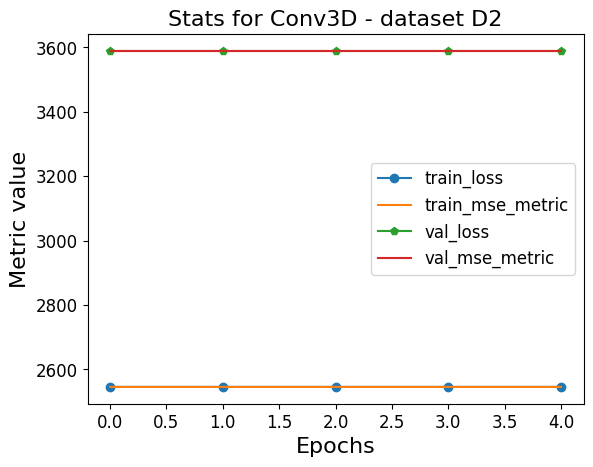

In [204]:
# Results of updated model6

plt.plot(history_conv3['loss'],'-o')
plt.plot(history_conv3['mean_squared_error'])
plt.plot(history_conv3['val_loss'],'-p')
plt.plot(history_conv3['val_mean_squared_error'])

plt.title('Stats for Conv3D - dataset D2', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Metric value', fontsize = 16)
plt.legend(['train_loss','train_mse_metric','val_loss','val_mse_metric'], fontsize = 12)
plt.show()

1/1 [==============================] - 0s 148ms/step
mse 3437.1101165222494
r2 score is: -7.302602356873641 

discrete values, predicted and real respectively: 1.0 70.52999877929688


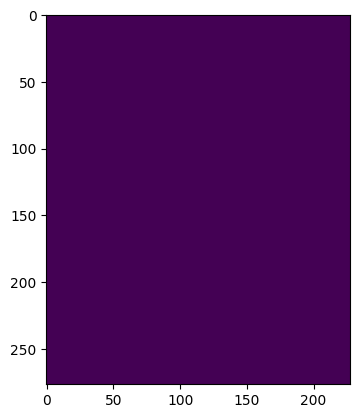

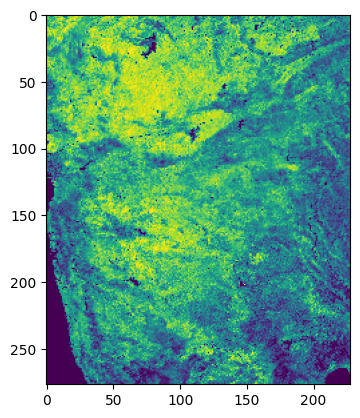

In [205]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
framed = x_test[1][:1,...]
pred = model_conv3.predict(np.expand_dims(framed, axis=0))
y_real = y_test[1][0]
pred = pred.reshape(277,228,1)
plt.imshow(pred.reshape(277,228))
plt.figure()
plt.imshow(y_real.reshape(277,228))
r2 = r2_score(y_real.reshape(277,228),pred.reshape(277,228))
mse = mse(y_real.reshape(277,228),pred.reshape(277,228))
print("mse",mse)
print("r2 score is:", r2,"\n")
pred = pred.reshape(277,228)
y_real = y_real.reshape(277,228)
print("discrete values, predicted and real respectively:",(pred.reshape(277,228))[50][30],(y_real.reshape(277,228))[50][30])

In [206]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))
inp.shape

TensorShape([None, None, 277, 228, 1])

In [207]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)
#x = layers.Dropout(0.3)(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.3)(x)
#x = layers.UpSampling3D((2, 2,2))(x)

x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#x = layers.UpSampling3D((2, 2,2))(x)
# x = layers.Dropout(0.3)(x)
x = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss='mse', optimizer=keras.optimizers.SGD(learning_rate=0.1),metrics=[tf.keras.metrics.mse]
)
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, None, 277, 228,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_12 (ConvLSTM2D)  (None, None, 277, 228, 1  9856     
                             6)                                  
                                                                 
 batch_normalization_12 (Bat  (None, None, 277, 228, 1  64       
 chNormalization)            6)                                  
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, None, 277, 228, 3  55424    
                             2)                                  
                                                                 
 batch_normalization_13 (Bat  (None, None, 277, 228, 3  12

In [208]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 2

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/5
14/14 [==============================] - 464s 32s/step - loss: 2548.4119 - mean_squared_error: 2548.4121 - val_loss: 3589.8933 - val_mean_squared_error: 3589.8933 - lr: 0.1000
Epoch 2/5


KeyboardInterrupt: 

In [209]:
data = full_data
data.shape

(40, 277, 228)

In [18]:
seq = keras.Sequential(
    [
        keras.Input(shape = (None, *x_train.shape[2:])),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.Conv3D(filters=1, kernel_size=(3,3,3), activation='relu', padding='same')
    ]
)

seq.compile(loss='mse', optimizer='adam')
seq.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_8 (ConvLSTM2D)  (None, None, 277, 228, 1  9856      
                             6)                                  
                                                                 
 batch_normalization_8 (Batc  (None, None, 277, 228, 1  64       
 hNormalization)             6)                                  
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, None, 277, 228, 1  18496     
                             6)                                  
                                                                 
 batch_normalization_9 (Batc  (None, None, 277, 228, 1  64       
 hNormalization)             6)                                  
                                                                 
 conv_lstm2d_10 (ConvLSTM2D)  (None, None, 277, 228, 1

In [243]:
len(train_dataset)

32

In [19]:
seq.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=20,
    validation_split=0.1
)

Epoch 1/20


 8/25 [========>.....................] - ETA: 50s - loss: 2028.1278

KeyboardInterrupt: 

In [245]:
pred = seq.predict(x_test)

1/1 [==============================] - 1s 1s/step


<AxesSubplot: >

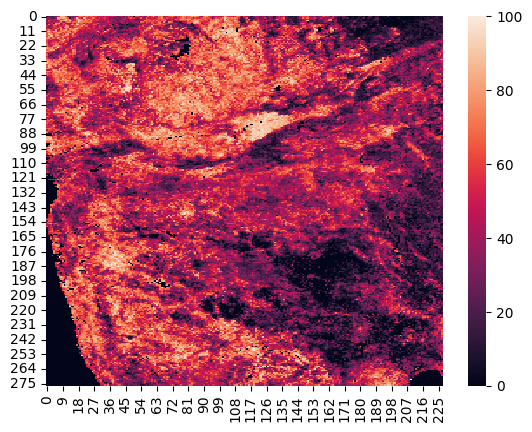

In [246]:
sns.heatmap(y_test[0][0].reshape((277, 228)))

<AxesSubplot: >

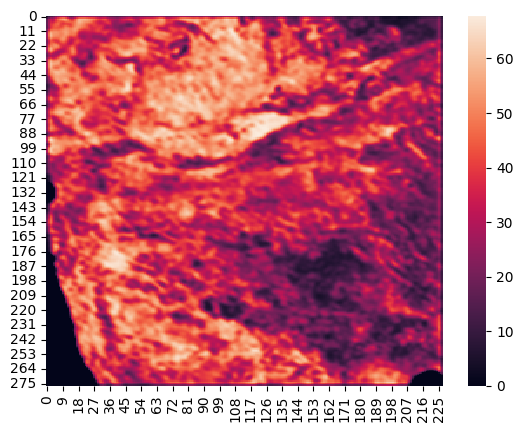

In [248]:
sns.heatmap(pred[0][0].reshape((277, 228)))

In [251]:
seq = keras.Sequential(
    [
        keras.Input(shape = (None, *x_train.shape[2:])),
        layers.ConvLSTM2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.Conv3D(filters=1, kernel_size=(3,3,3), activation='relu', padding='same')
    ]
)

seq.compile(loss='mse', optimizer='adam')
seq.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_65 (ConvLSTM2D)  (None, None, 277, 228, 8  2624     
                             )                                   
                                                                 
 batch_normalization_64 (Bat  (None, None, 277, 228, 8  32       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_66 (ConvLSTM2D)  (None, None, 277, 228, 1  13888    
                             6)                                  
                                                                 
 batch_normalization_65 (Bat  (None, None, 277, 228, 1  64       
 chNormalization)            6)                                  
                                                                 
 conv_lstm2d_67 (ConvLSTM2D)  (None, None, 277, 228, 

In [252]:
seq.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=50,
    validation_split=0.1
)

Epoch 1/50


25/25 [==============================] - 131s 5s/step - loss: 2371.0957 - val_loss: 4196.0742
Epoch 2/50
25/25 [==============================] - 115s 5s/step - loss: 2207.4358 - val_loss: 4181.1694
Epoch 3/50
25/25 [==============================] - 114s 5s/step - loss: 1998.8470 - val_loss: 3990.9187
Epoch 4/50
25/25 [==============================] - 115s 5s/step - loss: 1796.1177 - val_loss: 3584.0393
Epoch 5/50
25/25 [==============================] - 114s 5s/step - loss: 1613.1548 - val_loss: 3150.8035
Epoch 6/50
25/25 [==============================] - 119s 5s/step - loss: 1449.5409 - val_loss: 2966.6748
Epoch 7/50
25/25 [==============================] - 116s 5s/step - loss: 1301.3361 - val_loss: 2668.4651
Epoch 8/50
25/25 [==============================] - 116s 5s/step - loss: 1191.7296 - val_loss: 2296.8594
Epoch 9/50
25/25 [==============================] - 116s 5s/step - loss: 1081.3754 - val_loss: 2144.0232
Epoch 10/50
25/25 [==============================] - 116s 5s/step 

In [253]:
pred = seq.predict(x_test)

1/1 [==============================] - 2s 2s/step


<AxesSubplot: >

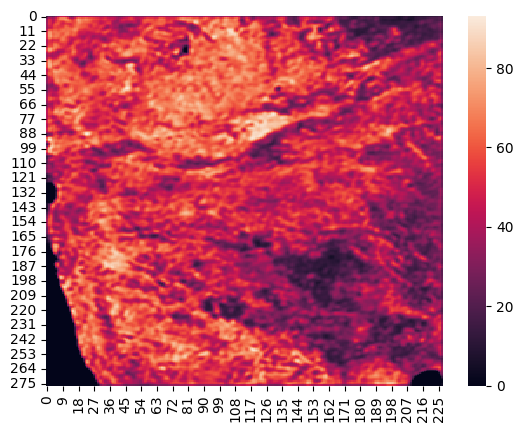

In [254]:
sns.heatmap(pred[0][0].reshape((277, 228)))

<AxesSubplot: >

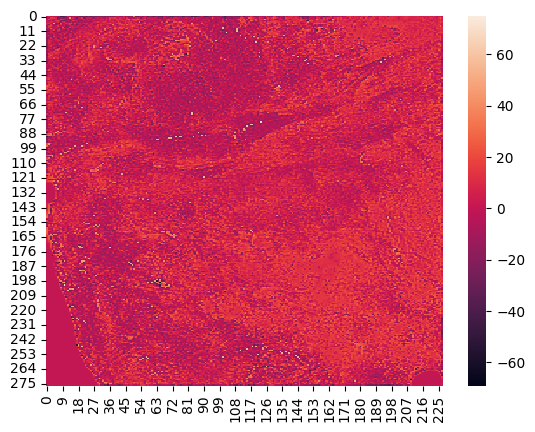

In [266]:
error = pred[0][0].reshape((277, 228)) - y_test[0][0].reshape((277, 228))
sns.heatmap(error)

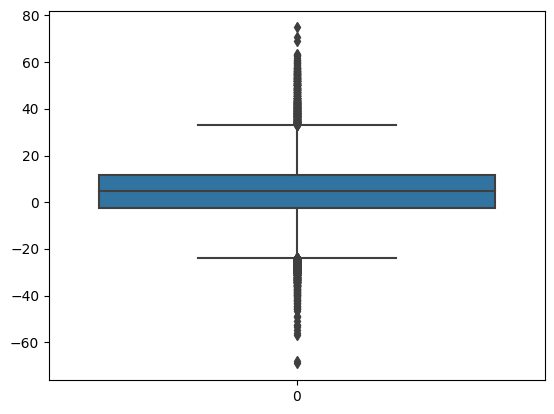

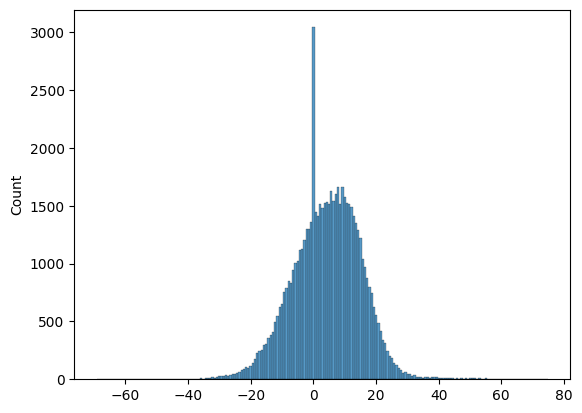

In [265]:
error = pred[0][0].reshape((277, 228)) - y_test[0][0].reshape((277, 228))
error = error.reshape((277*228))
sns.boxplot(error)
plt.show()
sns.histplot(error)
plt.show()

In [268]:
import pickle

pickle.dump(seq, open(rf"{os.getcwd()}/models/convlstm2d.pkl", "wb"))


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\conv3d
......vars
.........0
.........1
...layers\conv_lstm2d
......vars
...layers\conv_lstm2d\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_1
......vars
...layers\conv_lstm2d_1\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_2
......vars
...layers\conv_lstm2d_2\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_3
......vars
...layers\conv_lstm2d_3\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_4